In [80]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io
from datetime import datetime
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from sklearn.metrics import mean_squared_error
file_loc = "../Matlab/EERdatabase.xlsx"

In [81]:
# basically after they read in the file they do some calculation and turn them
# into a file call data_vars.mat
# 

# replicates the reading phase

# read in the files
cpi = pd.read_excel(file_loc, sheet_name="cpi",engine="openpyxl") 

USD = pd.read_excel(file_loc, sheet_name="ner_eop",engine="openpyxl") 

gdp = pd.read_excel(file_loc, sheet_name="gdppc_ppp",engine="openpyxl") 

nfa = pd.read_excel(file_loc, sheet_name="nfa2gdp",engine="openpyxl") 

tot = pd.read_excel(file_loc, sheet_name="tot_all",engine="openpyxl") 

weights = pd.read_excel(file_loc, sheet_name="weights_static",engine="openpyxl") 

# pre cleaning / define some variables that would be useful
time_line = cpi.iloc[:,0]
time_line = pd.DataFrame(time_line)
time_line.columns = ["Time"]
time_line["Time"] = pd.PeriodIndex(time_line["Time"], freq='Q').to_timestamp()
time_line["Year"] = time_line["Time"].dt.year
time_line["Q"] = time_line["Time"].dt.quarter

countries = list(cpi.columns)[1:]

# the first columns is always time, we DO NOT need them in the calculation
cpi = cpi.iloc[:,1:].to_numpy()
gdp = gdp.iloc[:,1:].to_numpy()
USD = USD.iloc[:,1:].to_numpy()
nfa = nfa.iloc[:,1:].to_numpy()
tot = tot.iloc[:,1:].to_numpy()

# weights

# following their reindexing into alphabetic order
weights.columns = ["country", 
"time", 
"USA", 
"GBR", 
"DNK",
"NOR",
"SWE", 
"CHE",
"CAN",
"JPN",
"EA",
"AUS",
"NZL"]
weights.set_index("country", inplace=True)
weights = weights.reindex(index=sorted(weights.index), columns=sorted(weights.columns))
# they fill the na with 0 for weights
weights = weights.fillna(0)
weights.drop(columns="time", inplace=True)
weights = weights.to_numpy()


# calculations below 

# log of relative CPI
rpi = np.log(cpi)- np.log(cpi)@weights
#  log of USD rate (increase stands for appreciation of dom. currency)
ner = np.log(USD)@weights - np.log(USD)
# log of USD real rate (increase stands for appreciation)
rer = ner + rpi

# log of relative gdp per capita
rgdp = np.log(gdp) - np.log(gdp)@weights

# log of relative terms of trade

rtot = np.log(tot) - np.log(tot)@weights

# relative nfa (choose which one)
rnfa = nfa-nfa@weights


### in the original code they get rid of denmark 
rpi = np.delete(rpi ,3,1)  
ner = np.delete(ner,3,1)  
rer = np.delete(rer,3,1) 
rgdp = np.delete(rgdp,3,1) 
rtot = np.delete(rtot,3,1) 
rnfa = np.delete(rnfa, 3,1)
countries.remove("DNK")


In [82]:
# A2_EqRERstimates

# periods in the paper (-1 in the end because Python)
period_start = 4*(1994-1975) + (4-1) +1 - 1
period_end = time_line.shape[0]

# this is the recursive part
# the regression table is the last recursive, meaning the from 80 to 176
#for i in range(period_start, period_end):
#    rerR = rer[0:i,:]
#    gdpR = rgdp[0:i,:]
#    nfaR = rnfa[0:i,:]
#    totR = rtot[0:i,:]

In [83]:

# because its Python the structure below makes way more sense
timeR = time_line.iloc[:period_end,:]

ner = pd.DataFrame(ner[0:period_end,:], columns=countries)
rerR = pd.DataFrame(rer[0:period_end,:], columns=countries)
gdpR = pd.DataFrame(rgdp[0:period_end,:], columns=countries)
nfaR = pd.DataFrame(rnfa[0:period_end,:], columns=countries)
totR = pd.DataFrame(rtot[0:period_end,:], columns=countries)

ner = pd.concat([timeR["Time"], ner], axis=1)
rerR = pd.concat([timeR["Time"], rerR], axis=1)
gdpR =  pd.concat([timeR["Time"], gdpR], axis=1)
nfaR =  pd.concat([timeR["Time"], nfaR], axis=1)
totR =  pd.concat([timeR["Time"], totR], axis=1)

ner = ner.melt(id_vars="Time", var_name="Country", value_name="ner")
rerR = rerR.melt(id_vars="Time", var_name="Country", value_name="rerR")
gdpR = gdpR.melt(id_vars="Time", var_name="Country", value_name="gdpR")
nfaR = nfaR.melt(id_vars="Time", var_name="Country", value_name="nfaR")
totR = totR.melt(id_vars="Time", var_name="Country", value_name="totR")


out = pd.merge(rerR, gdpR, how="left", left_on=["Time", "Country"], right_on=["Time", "Country"])
out = pd.merge(out, nfaR, how="left", left_on=["Time", "Country"], right_on=["Time", "Country"])
out = pd.merge(out, totR, how="left", left_on=["Time", "Country"], right_on=["Time", "Country"])

out["Country"] = out["Country"].astype("category")
out.set_index(['Country', 'Time'], inplace=True)
exog_vars = out[["gdpR", "nfaR", "totR"]]
mod1 = PanelOLS(out.rerR, exog_vars, entity_effects=True, time_effects=True).fit()
# the fixed effects of both the country and time_effects is closest to the results
mod1

C:\Anaconda3\lib\site-packages\linearmodels\panel\data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


Dep. Variable:,rerR,R-squared:,0.2449
Estimator:,PanelOLS,R-squared (Between):,-0.0293
No. Observations:,1760,R-squared (Within):,0.2436
Date:,"Thu, Feb 10 2022",R-squared (Overall):,-0.0280
Time:,10:11:28,Log-likelihood,1497.7
Cov. Estimator:,Unadjusted,,
,,F-statistic:,169.99
Entities:,10,P-value,0.0000
Avg Obs:,176.00,Distribution:,"F(3,1572)"
Min Obs:,176.00,,
Max Obs:,176.00,F-statistic (robust):,169.99


In [84]:
values = pd.DataFrame(mod1.params)
pvalues = pd.DataFrame(mod1.pvalues)
final = values.join(pvalues)

exog_vars = out[["gdpR"]]
mod2 = PanelOLS(out.rerR, exog_vars, entity_effects=True, time_effects=True).fit()
final = pd.concat([final, pd.DataFrame(mod2.params)], axis=1)
final = pd.concat([final, pd.DataFrame(mod2.pvalues)], axis=1)

exog_vars = out[["nfaR"]]
mod3 = PanelOLS(out.rerR, exog_vars, entity_effects=True, time_effects=True).fit()
final = pd.concat([final, pd.DataFrame(mod3.params)], axis=1)
final = pd.concat([final, pd.DataFrame(mod3.pvalues)], axis=1)


exog_vars = out[["totR"]]
mod4 = PanelOLS(out.rerR, exog_vars, entity_effects=True, time_effects=True).fit()
final = pd.concat([final, pd.DataFrame(mod4.params)], axis=1)
final = pd.concat([final, pd.DataFrame(mod4.pvalues)], axis=1)

final.columns = ["All Three Parameters", "All Three Parameters"] +  2*["GDP only"] + 2*["NFA only"] + 2*["ToT only"]


# adding values to out df
out["rer_b"] = mod1.fitted_values.to_numpy() + mod1.estimated_effects.to_numpy() # the equilibrium all(beer)
out["rer_gdp"] = mod2.fitted_values.to_numpy() + mod2.estimated_effects.to_numpy() # the equilibrium from gdpR
out["rer_nfa"] = mod3.fitted_values.to_numpy() + mod3.estimated_effects.to_numpy() # the equilibrium from nfaR
out["rer_tot"] = mod4.fitted_values.to_numpy() + mod4.estimated_effects.to_numpy() # the equilibrium from totR


In [85]:
final

,All Three Parameters,All Three Parameters,GDP only,GDP only,NFA only,NFA only,ToT only,ToT only
gdpR,0.191785,0.000076,0.264802,0.000002,NaN,NaN,NaN,NaN
nfaR,-0.019221,0.010966,NaN,NaN,-0.020547,0.01764,NaN,NaN
totR,0.424363,0.000000,NaN,NaN,NaN,NaN,0.42908,0.0


In [86]:
# testing another package with FullyModifiedOLS => result is less than ideal than PanelOLS with Fixed effects

from arch.unitroot.cointegration import FullyModifiedOLS

test = FullyModifiedOLS(out["rerR"].to_numpy(), out[["gdpR", "nfaR", "totR"]].to_numpy(), trend='c', x_trend="c").fit()
test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Fully Modified OLS                              
==============================================================================
Trend:                       Constant   No. Observations:                 1760
Kernel:                      Bartlett   R²:                             0.2286
Bandwidth:                         36   Adjusted. R²:                   0.2273
                                        Residual Variance:              2.3264
                                        Long-run Variance:              73.437
                                                                              
                             Cointegrating Vector                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
x1             1.9568     1.0836     1.8059     0.0709     -0.1669      4.0806
x2            -1.0664     0.3971    -2.6853     0.0072     -1.8447     -0.2880
x3            -2.3548     0.9987    -2.3579     0.0184     -4.3123     -0.3974
const         -0.3804     0.2154    -1.7662     0.0774     -0.8026      0.0417
==============================================================================
"""

In [87]:
## Graphs  (please ignore)
#para = fe_te_res.params.to_numpy()
#graph_df = out[["gdpR", "nfaR", "totR", "rerR"]]
#graph_df["gdpR"] = para[0]*graph_df["gdpR"]
#graph_df["nfaR"] = para[1]*graph_df["nfaR"]
#graph_df["totR"] = para[2]*graph_df["totR"]
#graph_df["prediction"] = graph_df["totR"] + graph_df["nfaR"] + graph_df["gdpR"]
#graph_df["rerR"] = out[["rerR"]]
#
##graph_df = graph_df.join(out[["rerR"]])
#graph_df.reset_index(inplace=True)
#test = graph_df[graph_df.Country=="CAN"]
#test["mean"] = test.rerR.mean()
#rho = 0.5**(1/12)
#test["prediction"] = rho*test["prediction"] + test["mean"]
#fig, ax = plt.subplots(figsize=(15,5))
#sns.lineplot(data= test, x="Time", y="prediction", ax=ax)
#sns.lineplot(data= test, x="Time", y="rerR", ax=ax)

In [88]:
out

rerR      gdpR      nfaR      totR     rer_b  \
Country Time                                                           
AUS     1975-01-01  1.203286  0.064907 -0.103271 -0.466169  0.977473   
        1975-04-01  1.205045  0.089453 -0.113219 -0.484205  0.977229   
        1975-07-01  1.189019  0.067790 -0.127241 -0.480575  0.955162   
        1975-10-01  1.221306  0.039716 -0.137298 -0.462310  0.970424   
        1976-01-01  1.233522  0.068694 -0.134981 -0.489449  0.973724   
...                      ...       ...       ...       ...       ...   
USA     2017-10-01  1.514888  0.277166 -0.620421  0.111772  1.432757   
        2018-01-01  1.498303  0.279582 -0.632006  0.110781  1.426018   
        2018-04-01  1.543900  0.283650 -0.674690  0.125251  1.427059   
        2018-07-01  1.546725  0.290584 -0.726276  0.133066  1.432963   
        2018-10-01  1.557716  0.292340 -0.718775  0.142939  1.431441   

                     rer_gdp   rer_nfa   rer_tot  
Country Time                                      
AUS     1975-01-01  1.011200  0.996525  0.980502  
        1975-04-01  1.018052  0.996873  0.975244  
        1975-07-01  0.992902  0.976607  0.956368  
        1975-10-01  0.997606  0.987694  0.976132  
        1976-01-01  1.017088  0.998968  0.973515  
...                      ...       ...       ...  
USA     2017-10-01  1.414828  1.418960  1.410200  
        2018-01-01  1.409755  1.413742  1.402711  
        2018-04-01  1.405311  1.409081  1.402005  
        2018-07-01  1.409277  1.412036  1.405399  
        2018-10-01  1.402771  1.404410  1.404095  

[1760 rows x 8 columns]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

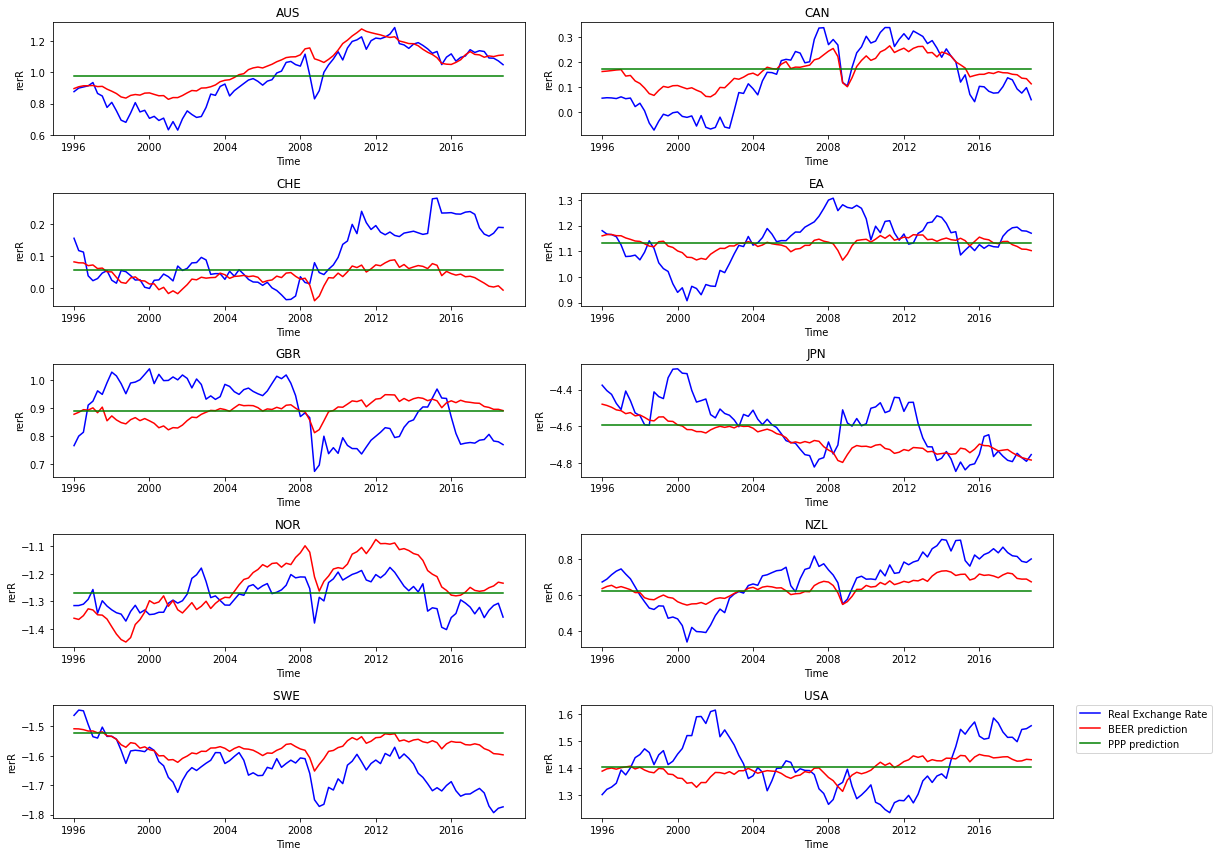

In [89]:
test = out[["rerR", "rer_b"]]
test.reset_index(inplace=True)

all_countries = ['AUS', 'CAN', 'CHE', 'EA', 'GBR', 'JPN', 'NOR', 'NZL', 'SWE ', 'USA']


fig, ax = plt.subplots(5, 2, figsize=(17,12))
count = 0
for i in range(5):
    for j in range(2):
        g_data = test[test["Country"] == all_countries[count]]
        g_data["rer_ppp"] =  g_data["rerR"].mean()
        test2 = g_data[g_data.Time.dt.year>1995]
        sns.lineplot(data=test2, x="Time", y="rerR", ax=ax[i,j], color="b",label="Real Exchange Rate")
        sns.lineplot(data=test2, x="Time", y="rer_b", ax=ax[i,j], color="r",label="BEER prediction")
        sns.lineplot(data=test2, x="Time", y="rer_ppp", ax=ax[i,j], color="g",label="PPP prediction")
        ax[i,j].title.set_text(all_countries[count])
        if count != 9:  
            ax[i,j].get_legend().remove()
        count +=1 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.tight_layout()

In [91]:
# opt contains T => TIME information
# t1 beginning periods
# K => number of forecast
# h => forecast horion 

rho = 0.5**(1/12) # see paper forecast on a napkin
h = 20 
test_data = test[test["Country"] == 'AUS']
test_data["rer_ppp"] =  test_data["rerR"].mean()
K = period_end - period_start -1 
#k is for for loop
count = 0
for k in range(K+1):
    t = period_start + k 
    input_re = test_data.iloc[t]["rerR"]
    input_eq = test_data.iloc[t]["rer_ppp"]
    if count == 0:
        forecast = (input_re-input_eq)*rho**np.arange(1, h+1, 1) + input_eq
        count += 1
    else:
        temp = (input_re-input_eq)*rho**np.arange(1, h+1, 1) + input_eq
        forecast = np.vstack((forecast,temp))
    
forecast = pd.DataFrame(forecast)   
columns_name = ["Horizon " + str(i) for i in range(1, 21, 1)]
forecast.columns = columns_name
forecast = forecast.iloc[:-1]

count  = 0
for k in range(K+1):
    t = period_start + k 
    lmao = list(test_data.iloc[t:t+h]["rerR"])
    fill = np.empty((1,20))
    fill[:] = np.NaN
    for i in range(len(lmao)):
        fill[0,i] = lmao[i]
    
    if count == 0:
        real = fill
        count += 1
    else:
        real = np.vstack((real,fill))

real = pd.DataFrame(real)   
columns_name = ["Horizon " + str(i) for i in range(1, 21, 1)]
real.columns = columns_name   
real = real.iloc[1:,]


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [92]:
predict_ppp_matlab = pd.DataFrame(scipy.io.loadmat('forecast_ppp.mat').get("fcst")[0][0][0]) # prediction from Matlab code
origin_ppp_matlab = pd.DataFrame(scipy.io.loadmat('forecast_ppp.mat').get("fcst")[0][0][1]) # real values

In [93]:
predict_ppp_matlab 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.845277,0.853655,0.861562,0.869026,0.876071,0.882720,0.888997,0.894921,0.900512,0.905790,0.910772,0.915473,0.919912,0.924100,0.928054,0.931786,0.935309,0.938633,0.941772,0.944734
1,0.732832,0.747328,0.761012,0.773927,0.786117,0.797624,0.808484,0.818735,0.828411,0.837543,0.846163,0.854299,0.861979,0.869227,0.876069,0.882526,0.888622,0.894375,0.899805,0.904930
2,0.712897,0.728311,0.742860,0.756593,0.769554,0.781788,0.793336,0.804236,0.814523,0.824234,0.833399,0.842050,0.850215,0.857922,0.865197,0.872063,0.878544,0.884661,0.890435,0.895884
3,0.821960,0.831134,0.839794,0.847967,0.855682,0.862964,0.869837,0.876324,0.882447,0.888227,0.893682,0.898831,0.903691,0.908278,0.912608,0.916694,0.920552,0.924193,0.927629,0.930873
4,0.825500,0.834362,0.842728,0.850623,0.858076,0.865110,0.871749,0.878016,0.883931,0.889514,0.894784,0.899758,0.904453,0.908884,0.913067,0.917015,0.920741,0.924258,0.927578,0.930711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1.128545,1.119910,1.111759,1.104067,1.096806,1.089952,1.083483,1.077377,1.071614,1.066175,1.061040,1.056194,1.051620,1.047303,1.043227,1.039381,1.035750,1.032324,1.029089,1.026036
92,1.123799,1.115482,1.107632,1.100223,1.093229,1.086628,1.080397,1.074516,1.068965,1.063725,1.058780,1.054112,1.049706,1.045548,1.041623,1.037918,1.034421,1.031120,1.028005,1.025065
93,1.084773,1.078684,1.072937,1.067512,1.062391,1.057558,1.052997,1.048691,1.044627,1.040791,1.037170,1.033753,1.030527,1.027483,1.024609,1.021897,1.019337,1.016920,1.014639,1.012486
94,1.083634,1.077645,1.071993,1.066658,1.061622,1.056869,1.052383,1.048148,1.044151,1.040379,1.036818,1.033457,1.030285,1.027290,1.024464,1.021796,1.019279,1.016902,1.014659,1.012542


In [94]:
origin_ppp_matlab

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.717473,0.696566,0.812240,0.816110,0.876728,0.899618,0.906619,0.913851,0.934920,0.865230,0.849048,0.776263,0.808489,0.754885,0.694840,0.681230,0.740410,0.806844,0.747502,0.757891
1,0.696566,0.812240,0.816110,0.876728,0.899618,0.906619,0.913851,0.934920,0.865230,0.849048,0.776263,0.808489,0.754885,0.694840,0.681230,0.740410,0.806844,0.747502,0.757891,0.706703
2,0.812240,0.816110,0.876728,0.899618,0.906619,0.913851,0.934920,0.865230,0.849048,0.776263,0.808489,0.754885,0.694840,0.681230,0.740410,0.806844,0.747502,0.757891,0.706703,0.719334
3,0.816110,0.876728,0.899618,0.906619,0.913851,0.934920,0.865230,0.849048,0.776263,0.808489,0.754885,0.694840,0.681230,0.740410,0.806844,0.747502,0.757891,0.706703,0.719334,0.693043
4,0.876728,0.899618,0.906619,0.913851,0.934920,0.865230,0.849048,0.776263,0.808489,0.754885,0.694840,0.681230,0.740410,0.806844,0.747502,0.757891,0.706703,0.719334,0.693043,0.707985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1.132611,1.091224,1.089979,1.072927,1.048645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,1.091224,1.089979,1.072927,1.048645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,1.089979,1.072927,1.048645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,1.072927,1.048645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
real

,Horizon 1,Horizon 2,Horizon 3,Horizon 4,Horizon 5,Horizon 6,Horizon 7,Horizon 8,Horizon 9,Horizon 10,Horizon 11,Horizon 12,Horizon 13,Horizon 14,Horizon 15,Horizon 16,Horizon 17,Horizon 18,Horizon 19,Horizon 20
1,0.717473,0.696566,0.812240,0.816110,0.876728,0.899618,0.906619,0.913851,0.934920,0.865230,0.849048,0.776263,0.808489,0.754885,0.694840,0.681230,0.740410,0.806844,0.747502,0.757891
2,0.696566,0.812240,0.816110,0.876728,0.899618,0.906619,0.913851,0.934920,0.865230,0.849048,0.776263,0.808489,0.754885,0.694840,0.681230,0.740410,0.806844,0.747502,0.757891,0.706703
3,0.812240,0.816110,0.876728,0.899618,0.906619,0.913851,0.934920,0.865230,0.849048,0.776263,0.808489,0.754885,0.694840,0.681230,0.740410,0.806844,0.747502,0.757891,0.706703,0.719334
4,0.816110,0.876728,0.899618,0.906619,0.913851,0.934920,0.865230,0.849048,0.776263,0.808489,0.754885,0.694840,0.681230,0.740410,0.806844,0.747502,0.757891,0.706703,0.719334,0.693043
5,0.876728,0.899618,0.906619,0.913851,0.934920,0.865230,0.849048,0.776263,0.808489,0.754885,0.694840,0.681230,0.740410,0.806844,0.747502,0.757891,0.706703,0.719334,0.693043,0.707985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,1.132611,1.091224,1.089979,1.072927,1.048645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,1.091224,1.089979,1.072927,1.048645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,1.089979,1.072927,1.048645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,1.072927,1.048645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
y_true = real["Horizon 20"].dropna().to_numpy()# python will throw error if na is included
length = len(y_true) 
y_pred = forecast["Horizon 20"].to_numpy()[:length]
mean_squared_error(y_true, y_pred, squared=False)

0.15793036328174107

In [97]:
# beer
rho = 0.5**(1/12) # see paper forecast on a napkin
h = 20 
test_data = test[test["Country"] == 'AUS']
#test_data["rer_ppp"] =  test_data["rerR"].mean()
K = period_end - period_start -1 
#k is for for loop
count = 0
for k in range(K+1):
    t = period_start + k 
    input_re = test_data.iloc[t]["rerR"]
    input_eq = test_data.iloc[t]["rer_b"]
    if count == 0:
        forecast = (input_re-input_eq)*rho**np.arange(1, h+1, 1) + input_eq
        count += 1
    else:
        temp = (input_re-input_eq)*rho**np.arange(1, h+1, 1) + input_eq
        forecast = np.vstack((forecast,temp))
    
forecast = pd.DataFrame(forecast)   
columns_name = ["Horizon " + str(i) for i in range(1, 21, 1)]
forecast.columns = columns_name
forecast = forecast.iloc[:-1]
count  = 0
for k in range(K+1):
    t = period_start + k 
    lmao = list(test_data.iloc[t:t+h]["rerR"])
    fill = np.empty((1,20))
    fill[:] = np.NaN
    for i in range(len(lmao)):
        fill[0,i] = lmao[i]
    
    if count == 0:
        real = fill
        count += 1
    else:
        real = np.vstack((real,fill))

real = pd.DataFrame(real)   
columns_name = ["Horizon " + str(i) for i in range(1, 21, 1)]
real.columns = columns_name   
real = real.iloc[1:,]

In [98]:
predict_beer_matlab = pd.DataFrame(scipy.io.loadmat('forecast_beer.mat').get("fcst")[0][0][0]) # prediction from Matlab code
origin_beer_matlab = pd.DataFrame(scipy.io.loadmat('forecast_beer.mat').get("fcst")[0][0][1]) # real values

In [99]:
predict_beer_matlab

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.838390,0.840267,0.842040,0.843712,0.845291,0.846781,0.848188,0.849515,0.850768,0.851951,0.853067,0.854121,0.855116,0.856054,0.856941,0.857777,0.858566,0.859311,0.860015,0.860678
1,0.726324,0.734679,0.742565,0.750009,0.757035,0.763666,0.769925,0.775833,0.781409,0.786673,0.791641,0.796330,0.800756,0.804933,0.808876,0.812598,0.816111,0.819426,0.822556,0.825510
2,0.705627,0.714180,0.722252,0.729872,0.737064,0.743852,0.750259,0.756307,0.762015,0.767403,0.772488,0.777288,0.781819,0.786095,0.790131,0.793941,0.797537,0.800931,0.804134,0.807158
3,0.814982,0.817571,0.820014,0.822320,0.824496,0.826550,0.828489,0.830320,0.832047,0.833678,0.835217,0.836669,0.838040,0.839334,0.840556,0.841709,0.842797,0.843824,0.844794,0.845709
4,0.818634,0.821017,0.823265,0.825388,0.827391,0.829282,0.831067,0.832751,0.834341,0.835842,0.837258,0.838595,0.839857,0.841049,0.842173,0.843234,0.844236,0.845181,0.846074,0.846916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1.136908,1.136167,1.135468,1.134808,1.134186,1.133598,1.133043,1.132519,1.132025,1.131558,1.131117,1.130702,1.130309,1.129939,1.129589,1.129259,1.128948,1.128654,1.128377,1.128115
92,1.131943,1.131313,1.130718,1.130157,1.129627,1.129127,1.128655,1.128209,1.127788,1.127391,1.127017,1.126663,1.126329,1.126014,1.125717,1.125436,1.125171,1.124921,1.124685,1.124462
93,1.093747,1.096127,1.098374,1.100495,1.102497,1.104386,1.106170,1.107853,1.109442,1.110942,1.112357,1.113693,1.114955,1.116145,1.117268,1.118329,1.119330,1.120275,1.121166,1.122008
94,1.092696,1.095262,1.097683,1.099968,1.102125,1.104162,1.106083,1.107897,1.109609,1.111225,1.112751,1.114190,1.115549,1.116832,1.118043,1.119185,1.120264,1.121282,1.122243,1.123150


In [100]:
forecast

,Horizon 1,Horizon 2,Horizon 3,Horizon 4,Horizon 5,Horizon 6,Horizon 7,Horizon 8,Horizon 9,Horizon 10,Horizon 11,Horizon 12,Horizon 13,Horizon 14,Horizon 15,Horizon 16,Horizon 17,Horizon 18,Horizon 19,Horizon 20
0,0.838176,0.839851,0.841433,0.842926,0.844334,0.845664,0.846920,0.848104,0.849223,0.850278,0.851274,0.852215,0.853102,0.853940,0.854731,0.855477,0.856182,0.856847,0.857474,0.858067
1,0.725266,0.732623,0.739566,0.746120,0.752306,0.758145,0.763656,0.768858,0.773768,0.778402,0.782776,0.786905,0.790802,0.794480,0.797952,0.801228,0.804321,0.807241,0.809996,0.812597
2,0.705297,0.713538,0.721317,0.728659,0.735588,0.742129,0.748303,0.754130,0.759631,0.764822,0.769722,0.774347,0.778713,0.782833,0.786723,0.790394,0.793859,0.797129,0.800216,0.803130
3,0.815865,0.819287,0.822516,0.825564,0.828442,0.831157,0.833721,0.836140,0.838424,0.840579,0.842613,0.844534,0.846346,0.848057,0.849672,0.851196,0.852634,0.853992,0.855274,0.856484
4,0.819721,0.823128,0.826345,0.829381,0.832246,0.834951,0.837504,0.839913,0.842188,0.844335,0.846361,0.848273,0.850078,0.851782,0.853391,0.854908,0.856341,0.857694,0.858970,0.860175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1.136203,1.134797,1.133470,1.132217,1.131034,1.129918,1.128865,1.127870,1.126932,1.126046,1.125210,1.124420,1.123675,1.122972,1.122309,1.121682,1.121091,1.120533,1.120006,1.119509
92,1.130565,1.128633,1.126810,1.125089,1.123465,1.121932,1.120485,1.119119,1.117830,1.116613,1.115465,1.114380,1.113357,1.112392,1.111480,1.110620,1.109807,1.109041,1.108317,1.107634
93,1.091971,1.092676,1.093342,1.093970,1.094563,1.095123,1.095651,1.096149,1.096620,1.097064,1.097484,1.097879,1.098253,1.098605,1.098938,1.099252,1.099549,1.099828,1.100093,1.100342
94,1.090559,1.091106,1.091623,1.092111,1.092571,1.093006,1.093416,1.093803,1.094168,1.094513,1.094839,1.095146,1.095436,1.095710,1.095968,1.096212,1.096442,1.096659,1.096864,1.097058


In [101]:
y_true = real["Horizon 20"].dropna().to_numpy()# python will throw error if na is included
length = len(y_true) 
y_pred = forecast["Horizon 20"].to_numpy()[:length]
mean_squared_error(y_true, y_pred, squared=False)


0.1457529497374738